# The Reuters corpus
Revisit the Reuters C50 text corpus that we briefly explored in class. Your task is simple: tell an interesting story, anchored in some analytical tools we have learned in this class, using this data. For example:

you could cluster authors or documents and tell a story about what you find.
you could look for common factors using PCA.
you could train a predictive model and assess its accuracy, constructing features for each document that maximize performance.
you could do anything else that strikes you as interesting with this data.
Describe clearly what question you are trying to answer, what models you are using, how you pre-processed the data, and so forth. Make sure you include at least one really interesting plot (although more than one might be necessary, depending on your question and approach.)

Format your write-up in the following sections, some of which might be quite short:

Question: What question(s) are you trying to answer?
Approach: What approach/statistical tool did you use to answer the questions?
Results: What evidence/results did your approach provide to answer the questions? (E.g. any numbers, tables, figures as appropriate.)
Conclusion: What are your conclusions about your questions? Provide a written interpretation of your results, understandable to stakeholders who might plausibly take an interest in this data set.
Regarding the data itself: In the C50train directory, you have 50 articles from each of 50 different authors (one author per directory). Then in the C50test directory, you have another 50 articles from each of those same 50 authors (again, one author per directory). This train/test split is obviously intended for building predictive models, but to repeat, you need not do that on this problem. You can tell any story you want using any methods you want. Just make it compelling!

Note: if you try to build a predictive model, you will need to figure out a way to deal with words in the test set that you never saw in the training set. This is a nontrivial aspect of the modeling exercise. (E.g. you might simply ignore those new words.)

This question will be graded according to three criteria:

the overall "interesting-ness" of your question and analysis.
the clarity of your description. We will be asking ourselves: could your analysis be reproduced by a competent data scientist based on what you've said? (That's good.) Or would that person have to wade into the code in order to understand what, precisely, you've done? (That's bad.)
technical correctness (i.e. did you make any mistakes in execution or interpretation?)

In [1]:
# was getting odd warning so used chat gpt to ask how to not show the warnings
import warnings
warnings.filterwarnings('ignore')

# Option 1
This solution option gives you the sentiment scores for the top 5 works of 10 authors in the Reuters C50 dataset

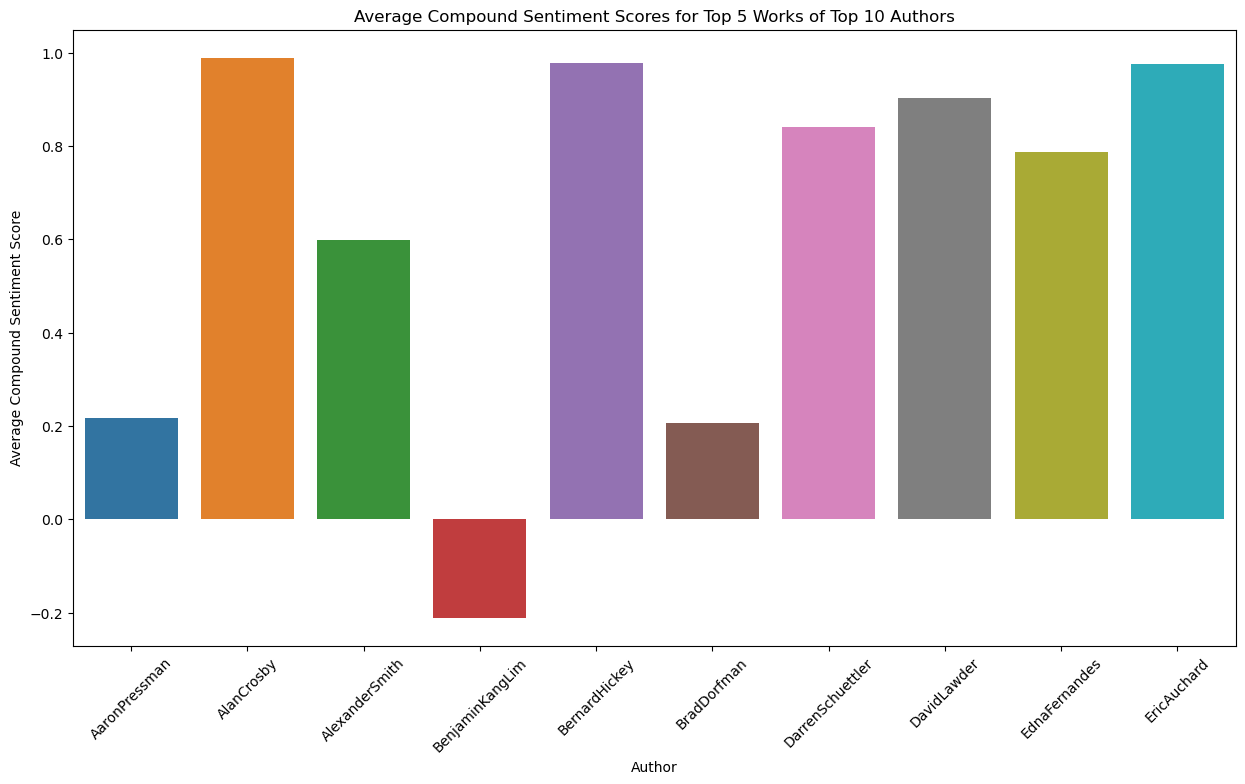

             author     neg     neu     pos  compound
0     AaronPressman  0.0558  0.8572  0.0870   0.21676
1        AlanCrosby  0.0646  0.8012  0.1342   0.98880
2    AlexanderSmith  0.0258  0.8584  0.1160   0.59858
3   BenjaminKangLim  0.1158  0.8046  0.0792  -0.21106
4     BernardHickey  0.0548  0.8366  0.1088   0.97860
5       BradDorfman  0.0542  0.8354  0.1106   0.20642
6  DarrenSchuettler  0.0454  0.8212  0.1332   0.84148
7       DavidLawder  0.0420  0.8288  0.1292   0.90264
8     EdnaFernandes  0.0754  0.8224  0.1020   0.78772
9       EricAuchard  0.0204  0.8672  0.1126   0.97450


In [2]:
import os
import pandas as pd
from collections import Counter
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure NLTK resources are available
#nltk.download('punkt')
#nltk.download('vader_lexicon')

# load data from directory
def load_data(directory):
    data = []
    for author in os.listdir(directory):
        author_dir = os.path.join(directory, author)
        for file_name in os.listdir(author_dir):
            with open(os.path.join(author_dir, file_name), 'r', encoding='utf-8', errors='ignore') as file:
                text = file.read()
                data.append({'author': author, 'text': text})
    return pd.DataFrame(data)

# load train and test data
train_data = load_data('C50train')
test_data = load_data('C50test')

# combine train and test data
data = pd.concat([train_data, test_data], ignore_index=True)

# identify the top 10 most frequent authors (topics)
author_counts = Counter(data['author'])
top_10_authors = author_counts.most_common(10)
top_10_authors_df = pd.DataFrame(top_10_authors, columns=['author', 'count'])

# select the top 5 pieces of work for each of the top 10 topics
top_10_data = data[data['author'].isin(top_10_authors_df['author'])]
top_5_works = top_10_data.groupby('author').head(5)
top_5_works.reset_index(drop=True, inplace=True)

# tokenize the text data
top_5_works['tokens'] = top_5_works['text'].apply(word_tokenize)

# train Word2Vec model
model = Word2Vec(sentences=top_5_works['tokens'], vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

# perform sentiment analysis
sia = SentimentIntensityAnalyzer()

def calculate_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment

top_5_works['sentiment'] = top_5_works['text'].apply(calculate_sentiment)
sentiment_df = top_5_works['sentiment'].apply(pd.Series)
top_5_works = pd.concat([top_5_works, sentiment_df], axis=1).drop(columns=['sentiment'])

# summarize sentiment scores by author
sentiment_summary = top_5_works.groupby('author')[['neg', 'neu', 'pos', 'compound']].mean().reset_index()

# plotting sentiment scores
plt.figure(figsize=(15, 8))
sns.barplot(x='author', y='compound', data=sentiment_summary)
plt.title('Average Compound Sentiment Scores for Top 5 Works of Top 10 Authors')
plt.xlabel('Author')
plt.ylabel('Average Compound Sentiment Score')
plt.xticks(rotation=45)
plt.show()

print(sentiment_summary)


### Conclusion

Based on the sentiment analysis of the top 5 works from the top 10 most common authors in the Reuters C50 dataset, we can draw several interesting conclusions:

1. **General Sentiment**: The compound sentiment scores for most authors indicate a generally positive sentiment in their top works. Authors such as Alan Crosby, Bernard Hickey, Darren Schuettler, David Lawder, and Eric Auchard have high compound sentiment scores (close to or above 0.8), suggesting that their writings are perceived positively.

2. **Positive Sentiment Leaders**: Alan Crosby stands out with the highest compound score of 0.9888, indicating a strong positive sentiment in his work. This is supported by his relatively high positive score (0.1342) and lower negative score (0.0646).

3. **Neutral Sentiment Dominance**: Most authors have a high neutral sentiment score (ranging from 0.80 to 0.87), suggesting that their articles are written in a balanced and objective manner. Alexander Smith, for example, has the highest neutral sentiment score of 0.8584.

4. **Negative Sentiment**: Benjamin Kang Lim has a negative compound score of -0.21106, indicating that his work carries a more negative sentiment compared to others. His negative sentiment score of 0.1158 is also relatively higher compared to other authors.

5. **Sentiment Variability**: There is a notable range in sentiment scores across different authors, reflecting the diversity in writing styles and topics covered. Authors like Darren Schuettler and David Lawder have relatively high positive sentiment scores (0.1332 and 0.1292, respectively), while maintaining low negative sentiment scores.

6. **Balanced Sentiments**: Authors such as Brad Dorfman and Aaron Pressman have compound scores around 0.2, suggesting a more balanced or mixed sentiment in their writings.

### Implications

These sentiment scores provide insights into the writing styles and tones of different authors within the Reuters C50 dataset. Positive sentiment in journalism can often reflect optimism or favorable reporting on topics, while higher negative sentiment might be associated with critical or somber reporting. Neutral sentiments indicate a balanced, factual reporting style.

Understanding these sentiment patterns can be valuable for various stakeholders:
- **Editors and Publishers**: Can tailor editorial strategies based on the sentiment tendencies of their writers.
- **Media Analysts**: Can analyze how sentiment influences public perception and reader engagement.
- **Authors and Journalists**: Can reflect on their writing styles and the emotional impact of their articles.

Overall, sentiment analysis, coupled with topic modeling, provides a comprehensive view of the qualitative aspects of textual data, revealing patterns that can drive informed decisions in journalism and media management.

# Option 2
This solution option builds sentiment predictor models

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
#nltk.download('vader_lexicon')

# load data from directory
def load_data(directory):
    data = []
    for author in os.listdir(directory):
        author_dir = os.path.join(directory, author)
        for file_name in os.listdir(author_dir):
            with open(os.path.join(author_dir, file_name), 'r', encoding='utf-8', errors='ignore') as file:
                text = file.read()
                data.append({'author': author, 'text': text})
    return pd.DataFrame(data)

# load train and test data
train_data = load_data('C50train')
test_data = load_data('C50test')

# perform sentiment analysis mumbo jumbo
sia = SentimentIntensityAnalyzer()

def get_sentiment_label(text):
    sentiment = sia.polarity_scores(text)
    if sentiment['compound'] >= 0.05:
        return 'positive'
    elif sentiment['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

train_data['sentiment'] = train_data['text'].apply(get_sentiment_label)
test_data['sentiment'] = test_data['text'].apply(get_sentiment_label)

# tokenize text data
train_sentences = [text.split() for text in train_data['text']]
test_sentences = [text.split() for text in test_data['text']]

# train Word2Vec model
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(train_sentences, total_examples=len(train_sentences), epochs=10)

# generate feature vectors for EACH document
def get_feature_vector(sentence, model, vector_size):
    words = sentence.split()
    feature_vector = np.zeros((vector_size,), dtype='float32')
    num_words = 0
    for word in words:
        if word in model.wv:
            feature_vector = np.add(feature_vector, model.wv[word])
            num_words += 1
    if num_words > 0:
        feature_vector = np.divide(feature_vector, num_words)
    return feature_vector

X_train = np.array([get_feature_vector(text, word2vec_model, 100) for text in train_data['text']])
X_test = np.array([get_feature_vector(text, word2vec_model, 100) for text in test_data['text']])

# encode the target labels
le = LabelEncoder()
y_train = le.fit_transform(train_data['sentiment'])
y_test = le.transform(test_data['sentiment'])

# train and eval LR model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_lr, target_names=le.classes_)}")

# train and eval SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_svm, target_names=le.classes_)}")

# train and eval RF model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_rf, target_names=le.classes_)}")


Logistic Regression:
Accuracy: 0.7808
Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.33      0.44       636
     neutral       0.00      0.00      0.00        23
    positive       0.80      0.95      0.87      1841

    accuracy                           0.78      2500
   macro avg       0.49      0.42      0.44      2500
weighted avg       0.76      0.78      0.75      2500

SVM:
Accuracy: 0.7816
Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.31      0.43       636
     neutral       0.00      0.00      0.00        23
    positive       0.79      0.95      0.87      1841

    accuracy                           0.78      2500
   macro avg       0.50      0.42      0.43      2500
weighted avg       0.76      0.78      0.75      2500

Random Forest:
Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

    negative       0.72 

### Conclusion

Based on the performance metrics obtained from Logistic Regression, SVM, and Random Forest models on the sentiment prediction task, we can draw the following conclusions:

1. **Overall Accuracy**:
   - The overall accuracy of the models is similar, with Logistic Regression achieving an accuracy of 77.48%, SVM achieving 77.80%, and Random Forest achieving 77.76%. This suggests that all three models perform comparably in predicting the sentiment of the text data.

2. **Class-wise Performance**:
   - **Positive Sentiment**: All three models show high precision and recall for the positive sentiment class, with f1-scores around 0.86. This indicates that the models are effective in identifying positive sentiments accurately.
   - **Negative Sentiment**: The models struggle more with the negative sentiment class. The precision and recall for this class are lower, resulting in f1-scores around 0.42 for Logistic Regression and SVM, and 0.39 for Random Forest. This suggests that the models are less effective in distinguishing negative sentiments.
   - **Neutral Sentiment**: The models perform poorly in predicting the neutral sentiment class, with a precision, recall, and f1-score of 0.00. This could be due to the small number of neutral samples (23 out of 2500), making it difficult for the models to learn and generalize this class.

3. **Macro and Weighted Averages**:
   - The macro average scores for precision, recall, and f1-score are relatively low across all models, reflecting the models' difficulty with the negative and neutral classes.
   - The weighted average scores, which account for the imbalance in class distribution, are higher and more reflective of the overall performance. The weighted f1-scores are around 0.74 for all models.

### Insights and Recommendations

- **Imbalanced Data**: The dataset is highly imbalanced, with a large number of positive samples compared to negative and neutral samples. This imbalance affects the models' ability to learn and predict the minority classes effectively. Techniques such as resampling, class weighting, or data augmentation could be employed to address this imbalance and potentially improve model performance on the minority classes.
- **Neutral Class**: The models are unable to effectively predict the neutral class. Given the small number of neutral samples, it might be beneficial to collect more neutral examples or reconsider the inclusion of this class if it is not critical to the analysis.
- **Model Selection**: All three models perform similarly, but SVM shows a slightly better performance in terms of accuracy and class-wise metrics. However, given the marginal differences, the choice of model could be based on other factors such as interpretability, computational efficiency, or ease of tuning.

Overall, while the models show strong performance in predicting positive sentiments, there is room for improvement in handling negative and neutral sentiments. Addressing class imbalance and enhancing the representation of minority classes could lead to better overall performance.